# Redes Neuronales NLP

In [2]:
import pandas as pd
import sklearn as sklearn

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
import os

df=pd.read_csv(
     os.path.join('hatespeech_data', 'tweets_train.csv'),index_col=0
)

In [4]:
df.columns

Index(['tweet_id', 'author_id', 'conversation_id', 'text', 'Odio', 'Mujeres',
       'Comunidad LGBTQ+', 'Comunidades Migrantes', 'Pueblos Originarios'],
      dtype='object')

In [5]:
df['Odio']=df['Odio'].astype('category')
df['Mujeres']=df['Mujeres'].astype('category')
df['Comunidad LGBTQ+']=df['Comunidad LGBTQ+'].astype('category')
df['Comunidades Migrantes']=df['Comunidades Migrantes'].astype('category')
df['Pueblos Originarios']=df['Pueblos Originarios'].astype('category')

In [6]:
df['tweet_id']=df['tweet_id'].astype('category')
df['author_id']=df['author_id'].astype('category')

In [7]:
df['text']=df['text'].map(str).str.lower()

In [8]:
import string, re

def remove_punct(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split()).lower()

df['data']=df['text'].apply(remove_punct)

In [9]:
stop_words = [line.strip() for line in  open("stopwords-filter-es.txt", "r")]

In [12]:
df['data']=df['data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [13]:
import unicodedata

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 'COMBINING GRAVE ACCENT', 'COMBINING TILDE')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

df['data'] = df['data'].apply(strip_accents)
print(df['data'] )

0       amistad tipo peor siempre asi lskdkdnff https ...
1                    maraca culia voy matar perra mierdva
2       menos mal q recibe ano ropa blanca jajajajjaja...
3       cuantos infiltrados extranjeros ahi https t co...
4       encontrado guayaquil fecha sector norte autopi...
                              ...                        
2251                  queda orto puta madre pario tambien
2252             dnakd amaraslapatria miserable hijo puta
2253                       misael sanbenito callate mejor
2254    serviciotelcel msj hoy mentadas madre cada ees...
2255    cnnchile tv monica mire senor simple ciudadano...
Name: data, Length: 2256, dtype: object


In [14]:
labels=(df['Odio']!=0).astype(int)

In [60]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['data'].values)

input_array = tokenizer.texts_to_sequences(df['data'].values)

vocab_size = len(tokenizer.word_index) + 1  

In [61]:
print('tamano vocabulario : ',vocab_size)

tamano vocabulario :  12296


In [63]:
j=0
for id,word in zip(tokenizer.word_index.keys(),tokenizer.word_index.values()):
    print("|{0:15s}|{1:5s}|".format(id,str(word)))
    j+=1
    if j==20:
        break

|t              |1    |
|https          |2    |
|co             |3    |
|mujer          |4    |
|puta           |5    |
|si             |6    |
|q              |7    |
|mas            |8    |
|mierda         |9    |
|chile          |10   |
|ser            |11   |
|mapuche        |12   |
|inmigrantes    |13   |
|pais           |14   |
|solo           |15   |
|asi            |16   |
|extranjeros    |17   |
|mapuches       |18   |
|hijo           |19   |
|negro          |20   |


In [71]:
reverse_word_index = dict(
[(value, key) for (key, value) in tokenizer.word_index.items()])

[reverse_word_index[i] for i in input_array[0] if i!=0]

['amistad',
 'tipo',
 'peor',
 'siempre',
 'asi',
 'lskdkdnff',
 'https',
 't',
 'co',
 'bpnqzqr']

In [72]:
df['data'][0]

'amistad tipo peor siempre asi lskdkdnff https t co bpnqzqr'

In [77]:
max_len=np.max([len(array) for array in input_array])

In [88]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_array_padded = pad_sequences(input_array, padding='post', maxlen=max_len)

In [89]:
input_array_padded[0]

array([ 819,  179,   85,   67,   16, 3496,    2,    1,    3, 3497,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_array_padded, labels, test_size=0.2)

In [91]:
X_train.shape

(1804, 37)

# Red Neuronal MultiCapa

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 37, 100)           1229600   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,232,865
Trainable params: 1,232,865
Non-trainable params: 0
_________________________________________________________________


El modelo recurrente tiende a decrecer la performance. Una alternativa es utilizar embeddings pre-entranados

https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

In [102]:
batch_size = 32
history=model.fit(X_train,y_train.values,epochs=10,batch_size=batch_size,validation_data=(X_test, y_test.values),verbose=0)

In [103]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validacion')
    plt.title('Exactitud')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validacion')
    plt.title('Objetivo')
    plt.legend()

Exactitud Entrenamiento: 0.9889
Exactitud Testing:  0.7788


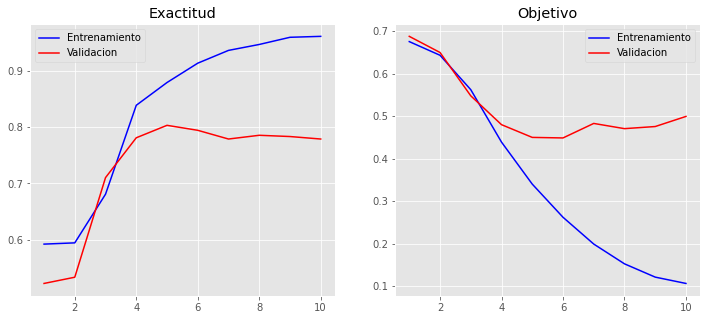

In [104]:
loss, accuracy = model.evaluate(X_train, y_train.values, verbose=False)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test.values, verbose=False)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

In [26]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test.values, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69       177
           1       0.80      0.82      0.81       275

    accuracy                           0.77       452
   macro avg       0.75      0.75      0.75       452
weighted avg       0.76      0.77      0.76       452



In [27]:
model.save('hatespeech_embedding.h5')

In [28]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Red Neuronal Recurrente